# Solar Panel Power

This notebook calculates the various parameters of the shadow cast by dipole antennae on a panel under them using a simple Monte Carlo algorithm. The light source is assumed to be point-like and at infinity.

The setup is as follows:
<img src="./antenna.png" style="width:600px">

We assume the antennae to be cylinders of radius $r_0=3cm$, at angles $\theta = \theta_0 \sim \pi/2$ and $\phi = \phi_0, \phi_0+\pi/2, \phi_0+\pi, \phi_0+3\pi/2$ starting  from $(0,0,h=0.1)$. The panel is a square surface of side $s=1m$ centered at the origin.

We assume the positive x-axis to point North, and the positive y-axis to point East. This gives the 3D setup as follows:

<div>
<img src="setup.gif" width="500">
</div>


In the Notebook below, we will compute the area and shape of the antenna shadow using a simple Monte Carlo technique.

###  Algorithm: Monte Carlo Shadow Finder

The essential idea is to compute whether a vector to the sun from a random point on the panel is blocked by the geometry of the antennae. This allows us to freely change the geometry of the problem at a later stage and also simplifies the computations required. 

Assuming the positive x-axis to point North, the positive y-axis points West. Then the Sun at a given Alt-Az corresponds to the polar location 
\begin{equation}
\theta_\odot = \pi/2 - Alt \\ \phi_\odot = 2\pi - Az
\end{equation}

After randomly choosing a point $P(p_x,p_y,0)$ on the panel, we construct the vector to the sun at a given Alt-Az by using its polar location:
\begin{equation}
\vec{S_\odot} = \sin(\theta_\odot) \cos(\phi_\odot) \hat{i} + \sin(\theta_\odot) \sin(\phi_\odot) \hat{j} + \cos(\theta_\odot) \hat{k}
\end{equation}

For the four antennae starting from $(0,0,h=0.1)$, we can define their axis vectors similarly:
\begin{equation}
\vec{A_i} = \sin(\theta_i) \cos(\phi_i) \hat{i} + \sin(\theta_i) \sin(\phi_i) \hat{j} + \cos(\theta_i) \hat{k}
\end{equation}

Now we check the shortest distance $d$ between the sun vector passing through $P(p_x,p_y,0)$, and the axis vector passing through $A(0,0,h)$:
\begin{equation}
d = |(\vec{P}-\vec{A}) \cdot \hat{n} |
\end{equation}
where $\hat{n}$ is the unit vector along $\vec{S_\odot} \times \vec{A_i}$. If this distance is less than the radius of the antenna, we conclude that the sun vector from P is blocked by the antenna.

Thus, for every randomly sampled point, we can check if the point is in shadow (blue) or not (orange), below:


<div>
<img src="shadow_area/lat0.gif" width="900">
<img src="shadow_area/lat30.gif" width="900">
<img src="shadow_area/lat-30.gif" width="900">

</div>


### Implementation:

I. For every Sun Alt-Az, we will sample the panel with randomly chosen points and save them as lists `inShadow` or `notInShadow` depending on the condition above. 

-Since the sampler uses a uniform distribution on the panel, the area of the shadow is simply the ratio $\frac{\#inShadow}{(\#inShadow \ + \ \#notInShadow)}$

-For the given latitudes, we precompute ~5000 points for every Sun position and save the lists inside `shadow_samples` labelled by the latitude and the Sun's Alt-Az. These lists can be appended to, in case further accuracy is required.

II. Using the lists we can now easily plot the points that were in shadow, and those that were not. Also, the area of the shadow is calculated and saved.

III. To obtain a function for the shadow area, we interpolate along the solar track (parametrized for now by the Alt-Az index itself).

For a uniform distribution of random samples, generating more samples improves accuracy in general. However, it gives diminishing returns on computation time, since most points are sampled from 'obviously' not-in-shadow areas. The appropriate way to improve this code is to implement a 'guess' distribution for the sampler that is close to the shadowed region - allowing for optimal resolution of the two areas.

This code can check ~5000 samples/second for each position, on a laptop with Intel i7-3rd Gen. For ~1400 positions per latitude, it takes about ~20 mins per latitude to sample all positions. Arguably, it might not be necessary to sample all 1400 positions since we can interpolate later. Total storage required is ~360MB per latitude. 

### Imports

##### Dependencies

`lusee`, `numpy`, `matplotlib`, `scipy`

`ImageMagick` for GIF animations

In [1]:
import lusee

In [2]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import norm
from scipy.interpolate import interp1d
import os

### Helper Function Definitions

In [3]:
def luseepy_sun_AltAz(night, lat):
    ## we use trickery to get sun latitude by setting long to zero
    obs = lusee.LObservation(night, lun_lat_deg=lat, lun_long_deg=0,  deltaT_sec=15*60)
    alt, az = obs.get_track_solar('sun')
    w=np.where(alt>0)
    return (alt[w],az[w])
    
def sun_vector(sun_alt, sun_az):
    # returns the Sun's polar coordinates given its Alt-Az
    # assumes that light source is at infinity
    # Note: ϕ=0 is North, ϕ=π/2 is West, ϕ=π is South, and ϕ=3π/2 is East, thus ϕ = 2π - azimuth
    # Note: θ=0 is Zenith, θ=π/2 is Horizon, thus θ = π/2 - altitude
    θ=np.pi/2 - sun_alt
    ϕ=2*np.pi - sun_az
    sun_vec = np.array([np.sin(θ)*np.cos(ϕ),np.sin(θ)*np.sin(ϕ),np.cos(θ)])
    
    return sun_vec

def random_point(side):
    rand_x=side*(np.random.random()-0.5)
    rand_y=side*(np.random.random()-0.5)
    rand_z=0
    
    return np.array([rand_x, rand_y, rand_z])

def to2D(point):
    x,y,z=point
    return np.array([x,y])

def antenna_axis_vector(θ, ϕ):
    axis_vec = np.array([np.sin(θ)*np.cos(ϕ),np.sin(θ)*np.sin(ϕ),np.cos(θ)])
    
    return axis_vec

def distance(a1, v1, a2, v2):
    # return distance between two lines defined as \vec{a}+t*\vec{b}
    a1=np.array(a1)
    a2=np.array(a2)
    normal_vec=np.cross(v1,v2)
    nhat=normal_vec/norm(normal_vec)
    distance = abs(np.dot(a2-a1, nhat))
    
    return distance

def shadow_check(point, sun_vec, antenna_origin, antenna_axis_vec, antenna_radius):
    distance_to_axis = distance(point, sun_vec, antenna_origin, antenna_axis_vec)
    shadow=True if distance_to_axis<antenna_radius else False
    
    return shadow

def monte_carlo_shadow(sun_vec, nsamples=1000):

    antenna_origin=np.array([0.0,0.0,0.1])
    antenna_axis_vec1=antenna_axis_vector(θ_antenna,ϕ_antenna)
    antenna_axis_vec2=antenna_axis_vector(θ_antenna,ϕ_antenna+np.pi/2)
    
    inShadow=[]
    notInShadow=[]
    for i in range(nsamples):
        point=random_point(side)

        shadowed1=shadow_check(point,sun_vec, antenna_origin, antenna_axis_vec1, antenna_radius=radius)
        shadowed2=shadow_check(point,sun_vec, antenna_origin, antenna_axis_vec2, antenna_radius=radius)
        shadowed = shadowed1 or shadowed2

        if shadowed:
            inShadow.append(to2D(point))
        else:
            notInShadow.append(to2D(point))
    
    return inShadow, notInShadow
        
def save_shadow_samples(night, lat, sun_alt, sun_az, inShadow, notInShadow):
    cwd=os.getcwd()
    path=f'/shadow_samples/night{night}_lat{lat}/'
    if not os.path.exists(cwd+path): os.makedirs(cwd+path)
    fname=f'sunAltAz_{sun_alt}_{sun_az}_'
    np.savetxt(cwd+path+fname+'inShadow.txt',inShadow)
    np.savetxt(cwd+path+fname+'noInShadow.txt',notInShadow)
    
def load_shadow_samples(night,lat, sun_alt, sun_az):
    path=f'./shadow_samples/night{night}_lat{lat}/'
    fname=f'sunAltAz_{sun_alt}_{sun_az}_'
    inShadow=np.loadtxt(path+fname+'inShadow.txt')
    notInShadow=np.loadtxt(path+fname+'noInShadow.txt')
    
    return inShadow, notInShadow

def plot_shadow_area_function(lat,**kwargs):
    shadow_area=np.loadtxt(f'./shadow_area/lat{lat}.txt')
    sun_altaz_index=range(len(shadow_area))
    shadow_area_function=interp1d(sun_altaz_index,shadow_area)
    
    ax=plt.gca()
    ax.plot(sun_altaz_index,shadow_area_function(sun_altaz_index),**kwargs)
    
def plot_shadow_area(lat, sun_alt, sun_az,**kwargs):
    inShadow, notInShadow=load_shadow_samples(lat,sun_alt,sun_az)
    
    ax=plt.gca()
    ax.scatter(inShadow,**kwargs)

### Panel, Antennae, Sun Alt-Az Setup

In [4]:
# set up panel constants
side=1.0 

# set up antennae constants
length=6.0; radius=0.015; θ_antenna=np.pi/2.0; ϕ_antenna=30.0*np.pi/180.0
height_above_panel=0.1
antenna_origin_offset=(0.0,0.0,height_above_panel)

# set up luseepy Sun Alt-Az
lat=30
night = 2500

### Run Monte Carlo Shadow Finder

In [5]:
## Est. runtime ~20 mins
print(f'calculating Sun AltAz for night={night} and lat={lat}')
sun_alt,sun_az=luseepy_sun_AltAz(night,lat)
npositions=len(sun_alt)

print('done, now calculating shadow samples...')
shadow_area=[]
for i,altaz in enumerate(zip(sun_alt,sun_az)):
    #percent progress
    if 10*i//npositions!=10*(i-1)//npositions: print(f'{100*i//npositions}% completed')
    
    #calculate if inShadow or notInShadow
    sun_vec=sun_vector(*altaz)
    inShadow, notInShadow=monte_carlo_shadow(sun_vec, nsamples=5000)
    save_shadow_samples(night, lat,*altaz,inShadow,notInShadow)
    
    #calculate shadow area
    area=len(inShadow)/(len(inShadow)+len(notInShadow))
    shadow_area.append(area)
    
    #save files
    np.savetxt(f'sun_AltAz_night{night}_lat{lat}.txt',np.column_stack([sun_alt,sun_az]))
    np.savetxt(f'shadow_area_night{night}_lat{lat}.txt', shadow_area)
print('done!')

calculating Sun AltAz for night=2500 and lat=30
done, now calculating shadow samples...
0% completed
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
done!


Text(0.5, 0.98, 'Antenna Shadow over time at Latitude=30')

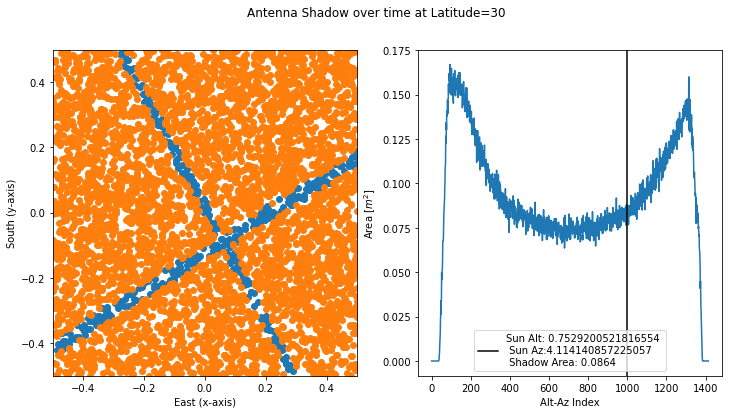

In [6]:
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# If you have run and saved all samples, you can change these values to see individual frames
sun_altaz_index=1000
#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

%matplotlib inline
fig,ax=plt.subplots(1,2, figsize=(12,6))
sun_alt,sun_az=np.loadtxt(f'sun_AltAz_night{night}_lat{lat}.txt', unpack=True)
# panel shadow plot
inShadow, notInShadow = load_shadow_samples(night,lat,sun_alt[sun_altaz_index],sun_az[sun_altaz_index])
if len(inShadow)!=0: ax[0].scatter(*inShadow.T,color='C0')
ax[0].scatter(*notInShadow.T,color='C1')
ax[0].set_xlim(-0.5,0.5)
ax[0].set_ylim(-0.5,0.5)
ax[0].set_xlabel('East (x-axis)')
ax[0].set_ylabel('South (y-axis)')

# area function
shadow_area=np.loadtxt(f'shadow_area_night{night}_lat{lat}.txt')
shadow_area_function=interp1d(range(len(shadow_area)),shadow_area)
ax[1].plot(range(len(shadow_area)),shadow_area_function(range(len(shadow_area))))
ax[1].axvline(x=sun_altaz_index, color='k', label=f'Sun Alt: {sun_alt[sun_altaz_index]} \n Sun Az:{sun_az[sun_altaz_index]} \n Shadow Area: {shadow_area_function(sun_altaz_index)}')
ax[1].set_ylabel('Area $[m^2]$')
ax[1].set_xlabel('Alt-Az Index')
ax[1].legend()

fig.suptitle(f'Antenna Shadow over time at Latitude={lat}')
# plt.savefig(f'./shadow_area/lat{lat}/{sun_altaz_index}.png')
# plt.close(fig)

### Creating the Animation GIF

We create all the frames of the animation and save them. Then use ImageMagick to combine them into a GIF.

```python

sun_alt,sun_az=np.loadtxt(f'sun_AltAz_night{night}_lat{lat}.txt', unpack=True)

for sun_altaz_index in range(0,len(sun_alt),20):
    fig,ax=plt.subplots(1,2, figsize=(12,6))

    # panel shadow plot
    inShadow, notInShadow = load_shadow_samples(lat,sun_alt[sun_altaz_index],sun_az[sun_altaz_index])
    if len(inShadow)!=0: ax[0].scatter(*inShadow.T,color='C0')
    ax[0].scatter(*notInShadow.T,color='C1')
    ax[0].set_xlim(-0.5,0.5)
    ax[0].set_ylim(-0.5,0.5)
    ax[0].set_xlabel('East (x-axis)')
    ax[0].set_ylabel('South (y-axis)')


    # area function
    shadow_area=np.loadtxt(f'shadow_area_night{night}_lat{lat}.txt')
    shadow_area_function=interp1d(range(len(shadow_area)),shadow_area)
    ax[1].plot(range(len(shadow_area)),shadow_area_function(range(len(shadow_area))))
    ax[1].axvline(x=sun_altaz_index, color='k', label=f'Sun Alt: {sun_alt[sun_altaz_index]} \n Sun Az:{sun_az[sun_altaz_index]} \n Shadow Area: {shadow_area_function(sun_altaz_index)}')
    ax[1].set_ylabel('Area $[m^2]$')
    ax[1].set_xlabel('Alt-Az Index')
    ax[1].legend()

    fig.suptitle(f'Antenna Shadow over time at Latitude={lat}')
    if not os.path.exists(f'./animation/night{night}_lat{lat}'): os.makedirs(f'./animation/night{night}_lat{lat}')
    plt.savefig(f'./animation/night{night}_lat{lat}/altaz_index{sun_altaz_index:04d}.png', dpi=96)
    plt.close(fig)
```
Here's a jupyter magic script to run the bash commands from within a cell!

```python
cwd=os.getcwd()
print(f'doing lat{lat}')
!convert -delay 8 {cwd}/animation/night_{night}_lat{lat}/*.png {cwd}/night{night}_lat{lat}.gif
print('done')
```